# Exploring the UTx000 Extension Beacon Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Evening IEQ Measurements
Now that we have parsed the beacon data into time periods corresponding to when participants were asleep, it would be interesting to analyze what concentrations are being experienced during the evening.

<div class="alert alert-block alert-warning">
    These data have not been filtered by GPS i.e. there might be some nights when participants are not home, which isn't too much of an issue considering we just want a look at nightly concentrations.

## Package Import

In [2]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Data Import

## Beacon Data

Processed beacon data

In [3]:
beacon = pd.read_csv('../data/processed/bpeace2-beacon.csv',
                        index_col=0,parse_dates=True,infer_datetime_format=True)
beacon.head()

,TVOC,eCO2,Lux,Visible,Infrared,NO2,T_NO2,RH_NO2,CO,T_CO,...,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,z,Beacon,Beiwe,Fitbit,REDCap
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4


Cross-referenced with Fitbit **ONLY**:

In [4]:
iaq_fb = pd.read_csv('../data/processed/bpeace2-fitbit-beacon-iaq-evening-full.csv',
                        index_col=0,parse_dates=True,infer_datetime_format=True)
iaq_fb.head()

,TVOC,eCO2,Lux,Visible,Infrared,NO2,T_NO2,RH_NO2,CO,T_CO,...,PM_C_4,PM_C_10,z,Beacon,Beiwe,Fitbit,REDCap,start_time,end_time,beiwe
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-07-17 01:55:00,162.96,677.28,0.0,0.0,0.0,NaN,NaN,NaN,49.16,27.0,...,19.965343,21.136512,0.059544,46,nvtfpaor,7,33,2020-07-17 01:53:00,2020-07-17 09:58:30,nvtfpaor
2020-07-17 02:00:00,154.00,629.40,0.0,0.0,0.0,NaN,NaN,NaN,NaN,27.0,...,14.195859,14.992534,0.057591,46,nvtfpaor,7,33,2020-07-17 01:53:00,2020-07-17 09:58:30,nvtfpaor
2020-07-17 02:05:00,145.12,609.44,0.0,0.0,0.0,NaN,NaN,NaN,49.16,27.0,...,15.194534,15.976830,0.078755,46,nvtfpaor,7,33,2020-07-17 01:53:00,2020-07-17 09:58:30,nvtfpaor
2020-07-17 02:10:00,152.52,619.88,0.0,0.0,0.0,NaN,NaN,NaN,49.16,27.0,...,15.422222,16.302358,0.152618,46,nvtfpaor,7,33,2020-07-17 01:53:00,2020-07-17 09:58:30,nvtfpaor
2020-07-17 02:15:00,156.76,637.80,0.0,0.0,0.0,NaN,NaN,NaN,NaN,27.0,...,11.971003,12.512567,0.150249,46,nvtfpaor,7,33,2020-07-17 01:53:00,2020-07-17 09:58:30,nvtfpaor


Cross-referenced with Fitbit **AND** EMAs:

In [5]:
iaq_fb_ema = pd.read_csv('../data/processed/bpeace2-beacon-fb_and_ema_restricted.csv',
                        index_col=0,parse_dates=True,infer_datetime_format=True)
iaq_fb_ema.head()

,TVOC,eCO2,Lux,Visible,Infrared,NO2,T_NO2,RH_NO2,CO,T_CO,...,PM_C_4,PM_C_10,z,Beacon,Beiwe,Fitbit,REDCap,start_time,end_time,beiwe
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-10 05:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,21,lkkjddam,25,12,2020-06-10 05:03:00,2020-06-10 11:52:30,lkkjddam
2020-06-10 05:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,21,lkkjddam,25,12,2020-06-10 05:03:00,2020-06-10 11:52:30,lkkjddam
2020-06-10 05:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,21,lkkjddam,25,12,2020-06-10 05:03:00,2020-06-10 11:52:30,lkkjddam
2020-06-10 05:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,21,lkkjddam,25,12,2020-06-10 05:03:00,2020-06-10 11:52:30,lkkjddam
2020-06-10 05:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,21,lkkjddam,25,12,2020-06-10 05:03:00,2020-06-10 11:52:30,lkkjddam


## Fitbit Sleep Data
Needed to restrict GPS dataset

In [6]:
sleep = pd.read_csv("../data/processed/bpeace2-fitbit-sleep-daily.csv",
                    parse_dates=['date','startTime','endTime'],infer_datetime_format=True)
end_dates = []
for d in sleep['endTime']:
    end_dates.append(d.date())
sleep['endDate'] = end_dates
sleep.head()

,date,dateOfSleep,duration,efficiency,endTime,infoCode,isMainSleep,logId,minutesAfterWakeup,minutesAsleep,minutesAwake,minutesToFallAsleep,startTime,timeInBed,beiwe,endDate
0,2020-05-14,2020-05-14,24360000,97,2020-05-14 07:13:00,0,True,27170628887,0,379,27,0,2020-05-14 00:27:00,406,hfttkth7,2020-05-14
1,2020-05-15,2020-05-15,29580000,87,2020-05-15 08:06:30,0,True,27187368950,8,392,101,0,2020-05-14 23:53:30,493,hfttkth7,2020-05-15
2,2020-05-16,2020-05-16,19740000,95,2020-05-16 04:57:00,0,True,27197675883,7,287,42,0,2020-05-15 23:28:00,329,hfttkth7,2020-05-16
3,2020-05-17,2020-05-17,26820000,96,2020-05-17 09:28:30,0,True,27214680283,8,403,44,0,2020-05-17 02:01:30,447,hfttkth7,2020-05-17
4,2020-05-18,2020-05-18,24960000,92,2020-05-18 07:20:00,0,True,27227113904,0,351,65,0,2020-05-18 00:24:00,416,hfttkth7,2020-05-18


## EMA Sleep Data
Morning EMA surveys

In [7]:
ema = pd.read_csv('../data/processed/bpeace2-morning-survey.csv',
                  index_col=0,parse_dates=True,infer_datetime_format=True)
ema.head()

,ID,Content,Stress,Lonely,Sad,Energy,TST,SOL,NAW,Restful
2020-07-31 09:25:41,hfttkth7,1.0,2.0,1.0,3.0,0.0,6.0,10.0,3.0,0.0
2020-08-19 22:49:04,hfttkth7,1.0,1.0,0.0,1.0,2.0,7.0,20.0,1.0,1.0
2020-08-23 10:58:26,hfttkth7,1.0,1.0,1.0,2.0,0.0,6.0,25.0,0.0,0.0
2020-07-17 09:52:16,hfttkth7,1.0,1.0,0.0,1.0,2.0,7.0,20.0,3.0,2.0
2020-08-12 12:32:54,hfttkth7,1.0,3.0,1.0,2.0,2.0,6.0,20.0,0.0,1.0


## GPS
GPS data, resampled to every 5-minutes

In [8]:
gps = pd.read_csv('../data/processed/bpeace2-gps.csv',
                 index_col=0,parse_dates=[0,1],infer_datetime_format=True)
gps.head()

,UTC Time,Lat,Long,Alt,Accuracy,Beiwe
Time,,,,,,
2020-05-06 01:00:00,2020-05-06 06:00:05.477,30.23705,-97.71051,135.77695,65.00000,15tejjtw
2020-05-06 02:05:00,2020-05-06 07:05:39.725,30.23706,-97.71049,135.84357,65.00000,15tejjtw
2020-05-06 02:06:00,2020-05-06 07:06:06.808,30.23706,-97.71049,135.84357,65.00000,15tejjtw
2020-05-06 03:01:00,2020-05-06 08:01:07.179,30.23716,-97.71047,139.34561,64.00967,15tejjtw
2020-05-06 03:02:00,2020-05-06 08:02:00.546,30.23716,-97.71047,139.34561,32.00483,15tejjtw


## Participant Info
Participant info, to check addresses with GPS coordinates

In [9]:
info = pd.read_excel('../data/raw/bpeace2/admin/id_crossover.xlsx',sheet_name='beacon',
                    parse_dates=[3,4,5,6],infer_datetime_format=True)
info.head()

,REDCap,Beiwe,Beacon,start_date,end_date,move_date,return_date,Lat,Long,original_start,original_end,original_move
0,10,kyj367pi,1,2020-06-08,2020-09-03,2020-07-31,2020-09-02,30.312614,-97.732338,2020-06-06,2020-09-03,2020-07-31
1,55,745vq78e,5,2020-06-08,2020-08-23,NaT,2020-09-08,30.288012,-97.751201,2020-06-08,2020-09-09,2020-09-09
2,61,itmylz3g,6,2020-06-15,NaT,NaT,NaT,29.855371,-95.741200,2020-06-15,NaT,2020-09-14
3,0,zdpffrox,7,2020-06-01,2020-09-01,NaT,2020-09-01,30.326815,-97.744665,2020-06-02,2020-09-14,2020-09-14
4,43,xlw5ntd5,10,2020-06-08,2020-09-11,2020-08-10,2020-09-22,30.351693,-97.614524,2020-06-06,NaT,2020-08-10


# Restricting the Beacon Dataset

In [10]:
import geopy.distance

Now we need to figure out a way to only include nights when participants are home. We can start by restricting GPS data to just nights when the participants are home. 

We can borrow code from Notebook 4.4.2 which restricts beacon data to fitbit times. 

<div class="alert alert-block alert-danger">
    
All of the code below to restrict the dataset to the fullest extent has been compiled into a function within build features (see next cell)

In [11]:
df = build_features.get_restricted_beacon_datasets()

Original code:

In [12]:
nightly_gps = pd.DataFrame() # dataframe holding the measured gps values for each pt
nightly_beacon = pd.DataFrame()
for pt in sleep['beiwe'].unique():
    if pt in info['Beiwe'].values:
        # getting data per participant
        gps_pt = gps[gps['Beiwe'] == pt]a
        sleep_pt = sleep[sleep['beiwe'] == pt]
        beacon_pt = beacon[beacon['Beiwe'] == pt]
        info_pt = info[info['Beiwe'] == pt]
        lat_pt = info_pt['Lat'].values[0]
        long_pt = info_pt['Long'].values[0]
        for start_time, end_time in zip(sleep_pt['startTime'],sleep_pt['endTime']):
            gps_pt_night = gps_pt[start_time:end_time]
            beacon_pt_night = beacon_pt[start_time:end_time]
            nightly_gps = nightly_gps.append(gps_pt_night)
            if len(gps_pt_night) > 0:
                coords_1 = (lat_pt, long_pt)
                coords_2 = (np.nanmean(gps_pt_night['Lat']), np.nanmean(gps_pt_night['Long']))
                d = geopy.distance.distance(coords_1, coords_2).m
                if d < 1000: # radius is less than 1000 m
                    gps_pt_night = gps_pt_night.resample('5T').mean()
                    beacon_pt_night = beacon_pt_night.resample('5T').mean()
                    nightly_temp = gps_pt_night.merge(right=beacon_pt_night,left_index=True,right_index=True,how='inner')
                    nightly_temp['start_time'] = start_time
                    nightly_temp['end_time'] = end_time
                    nightly_temp['Beiwe'] = pt

                    nightly_beacon = nightly_beacon.append(nightly_temp)
        

In [13]:
filtered_beacon = pd.DataFrame()
for pt in nightly_beacon['Beiwe'].unique():
    # getting pt-specific dfs
    evening_iaq_pt = nightly_beacon[nightly_beacon['Beiwe'] == pt]
    ema_pt = ema[ema['ID'] == pt]
    survey_dates = ema_pt.index.date
    survey_only_iaq = evening_iaq_pt[evening_iaq_pt['end_time'].dt.date.isin(survey_dates)]
    
    filtered_beacon = filtered_beacon.append(survey_only_iaq)
    
filtered_beacon.to_csv('../data/processed/bpeace2-beacon-fb_ema_and_gps_restricted.csv')

In [14]:
filtered_beacon

,Lat,Long,Alt,Accuracy,TVOC,eCO2,Lux,Visible,Infrared,NO2,...,PM_C_2p5,PM_C_4,PM_C_10,z,Beacon,Beiwe,Fitbit,REDCap,start_time,end_time
2020-08-10 05:10:00,30.58838,-97.425910,113.98145,5.29684,185.50,750.25,2.04,1.0,0.0,288.95,...,6.748117,10.714056,11.507244,1.441551,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:15:00,NaN,NaN,NaN,NaN,166.08,706.48,2.04,1.0,0.0,277.12,...,6.515844,10.288899,11.043510,1.468756,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:20:00,NaN,NaN,NaN,NaN,151.40,666.48,2.04,1.0,0.0,277.44,...,6.215933,9.795078,10.510907,1.492578,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:25:00,NaN,NaN,NaN,NaN,158.84,686.92,2.04,1.0,0.0,282.44,...,6.486098,10.357869,11.132223,1.457762,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:30:00,NaN,NaN,NaN,NaN,146.15,669.20,2.04,1.0,0.0,272.80,...,6.721101,10.739605,11.543306,1.430890,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27 05:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,17,9xmhtq74,50,59,2020-07-26 21:56:30,2020-07-27 06:52:00
2020-07-27 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,17,9xmhtq74,50,59,2020-07-26 21:56:30,2020-07-27 06:52:00
2020-07-27 06:05:00,30.75697,-94.417935,69.66934,47.50000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,17,9xmhtq74,50,59,2020-07-26 21:56:30,2020-07-27 06:52:00
2020-07-27 06:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,17,9xmhtq74,50,59,2020-07-26 21:56:30,2020-07-27 06:52:00


Now we can look at the gps traces for the evening in relation to the beacon measurements during the evening

Beiwe: lkkjddam, Beacon: 21


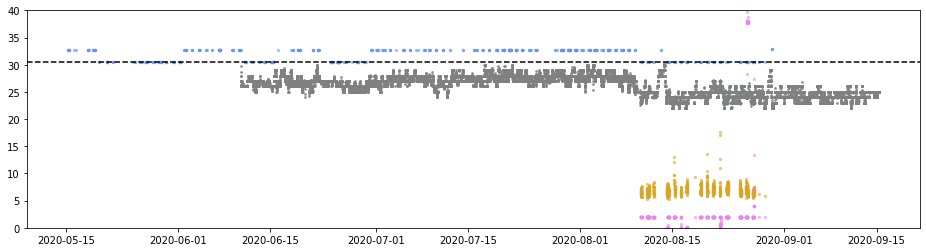

Beiwe: zdpffrox, Beacon: 7


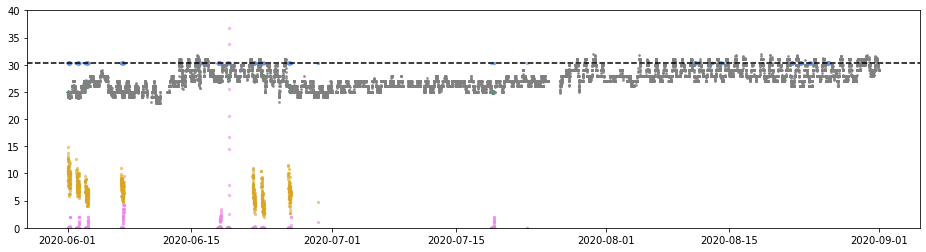

Beiwe: qh34m4r9, Beacon: 19


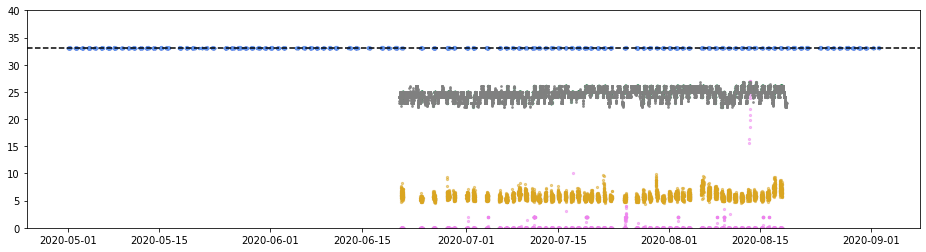

Beiwe: tmexej5v, Beacon: 29


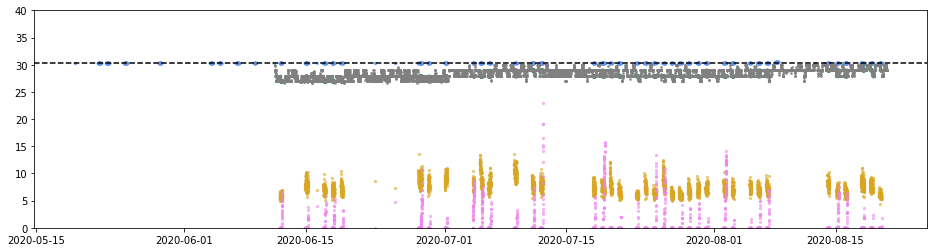

Beiwe: xlw5ntd5, Beacon: 10


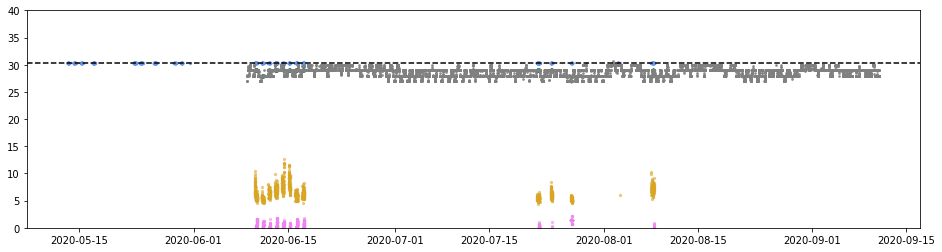

Beiwe: kyj367pi, Beacon: 1


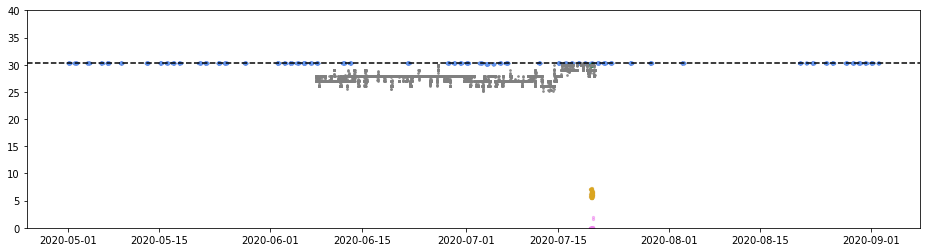

Beiwe: 745vq78e, Beacon: 5


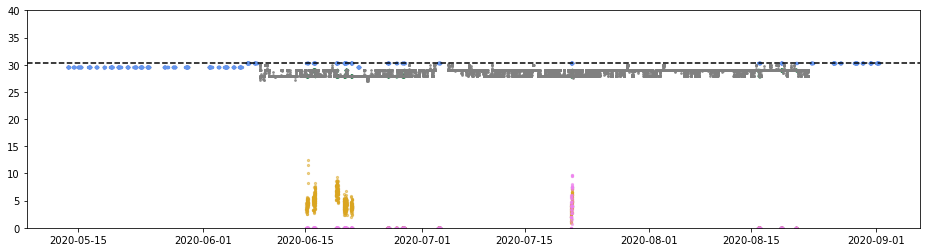

Beiwe: vr9j5rry, Beacon: 25


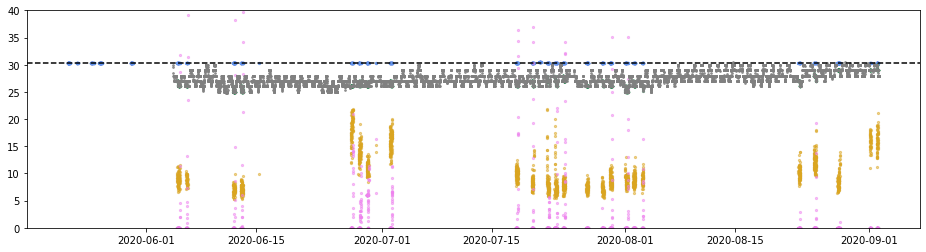

Beiwe: rnse61g4, Beacon: 34


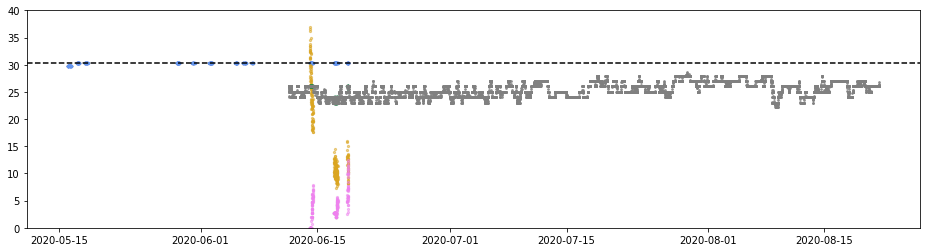

Beiwe: 4i7679py, Beacon: 44


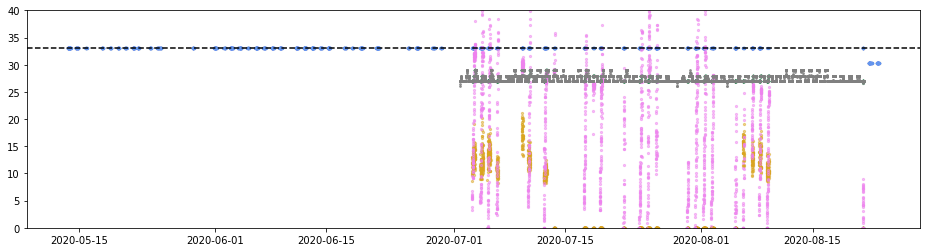

Beiwe: 9jtzsuu8, Beacon: 15


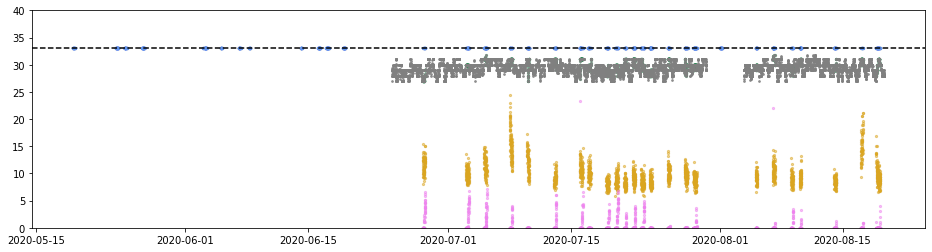

Beiwe: xdbdrk6e, Beacon: 24


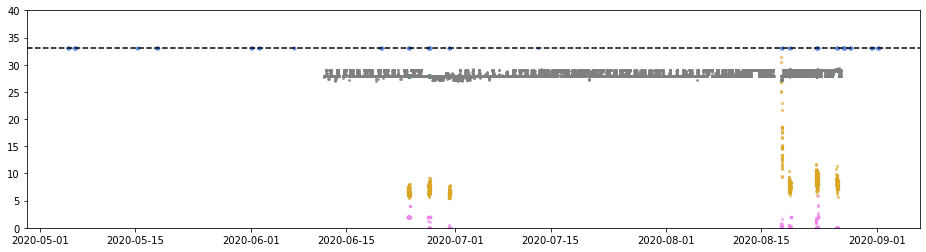

Beiwe: tlmlq19s, Beacon: 36


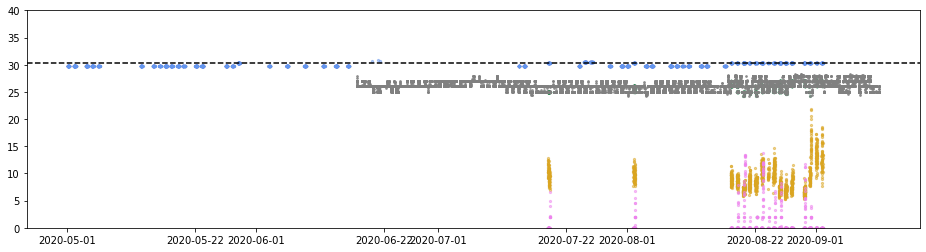

Beiwe: 9xmhtq74, Beacon: 17


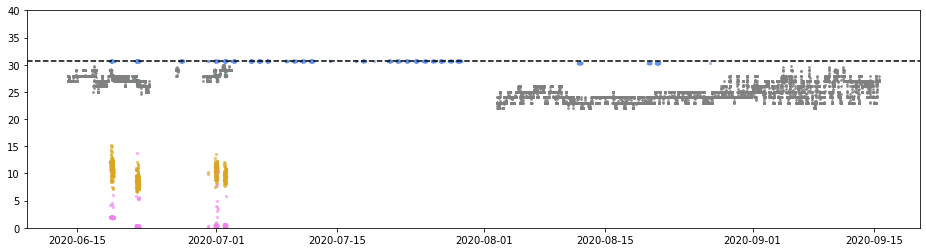

In [15]:
for pt in nightly_gps['Beiwe'].unique():
    if pt in info['Beiwe'].values:
        # gps data per individual
        gps_pt = nightly_gps[nightly_gps['Beiwe'] == pt]
        # beacon per individual
        night_beacon_pt = nightly_beacon[nightly_beacon['Beiwe'] == pt]
        beacon_pt = beacon[beacon['Beiwe'] == pt]
        # info per individual
        info_pt = info[info['Beiwe'] == pt]
        
        bb = info_pt['Beacon'].values[0]

        if len(night_beacon_pt['T_CO'].dropna()) > 100:
            print(f'Beiwe: {pt}, Beacon: {bb}')
            fig, ax = plt.subplots(figsize=(16,4))
            # Scattering Lat
            ax.scatter(gps_pt.index,gps_pt['Lat'], color='cornflowerblue', s=5,alpha=0.5)
            ax.axhline(info_pt['Lat'].values[0],color='black',linestyle='dashed')
            # Scattering Long
            #ax.scatter(gps_pt.index,gps_pt['Long'], color='firebrick', s=5,alpha=0.5)
            #ax.axhline(info_pt['Long'].values[0],color='black',linestyle='dashed')
            # Scattering beacon 
            ax.scatter(night_beacon_pt.index,night_beacon_pt['PM_C_2p5'], color='goldenrod', s=5,alpha=0.5)
            ax.scatter(night_beacon_pt.index,night_beacon_pt['T_CO'], color='seagreen', s=5,alpha=0.5)
            ax.scatter(night_beacon_pt.index,night_beacon_pt['Lux'], color='violet', s=5,alpha=0.5)
            ax.scatter(beacon_pt.index,beacon_pt['T_CO'],color='gray',alpha=0.8,s=3)

            ax.set_ylim([0,40])

            plt.show()
            plt.close()
            

# Visualization
Some base visualizations

## Helper Functions

In [16]:
def create_cmap(colors,nodes):
    cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
    return cmap

## Heatmap per Beacon

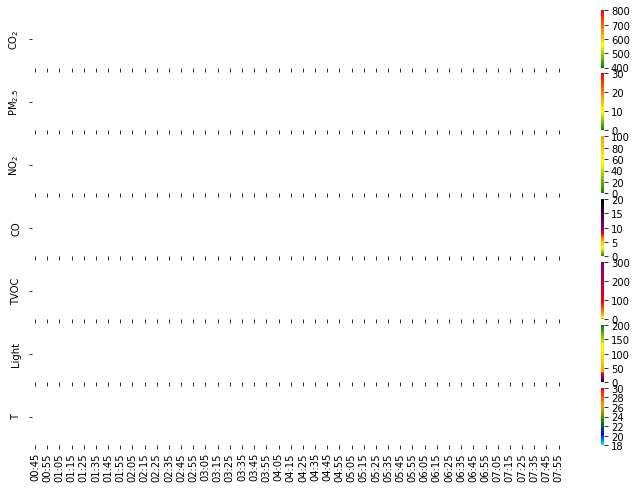

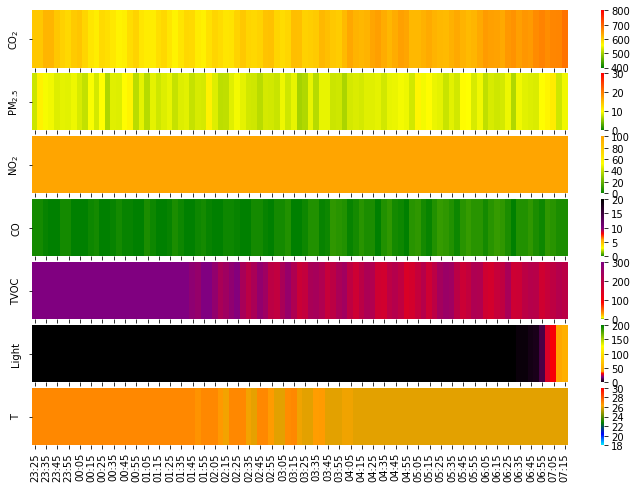

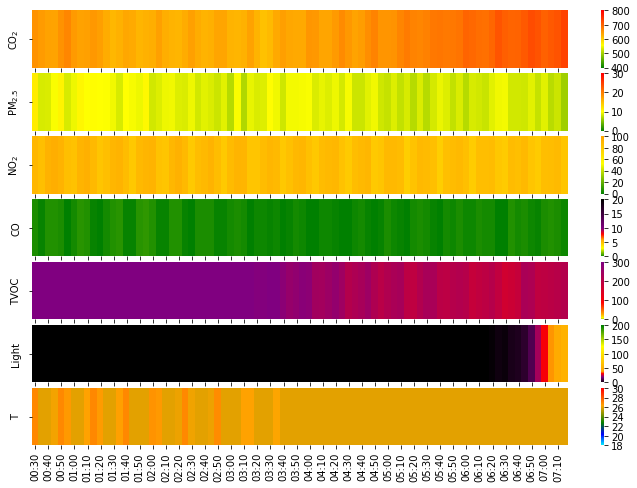

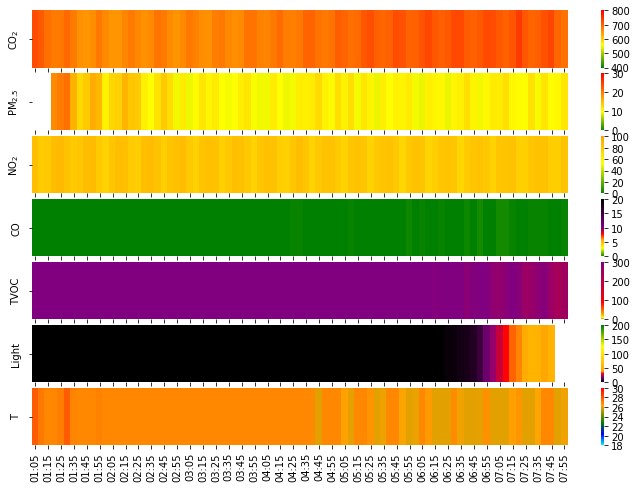

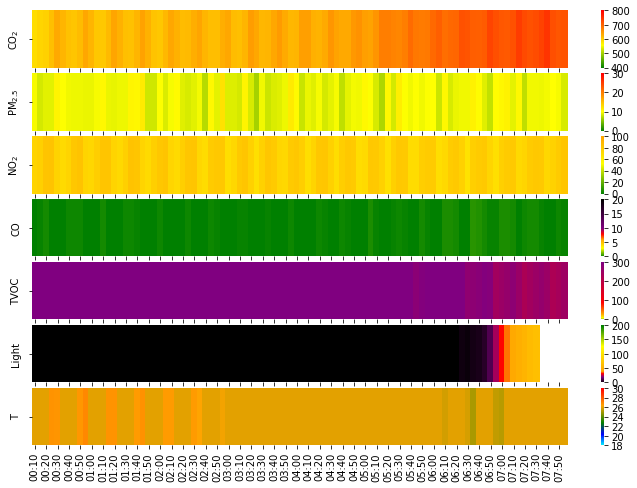

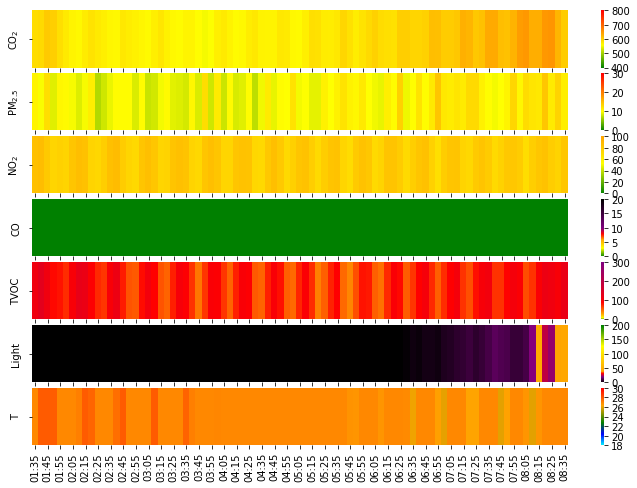

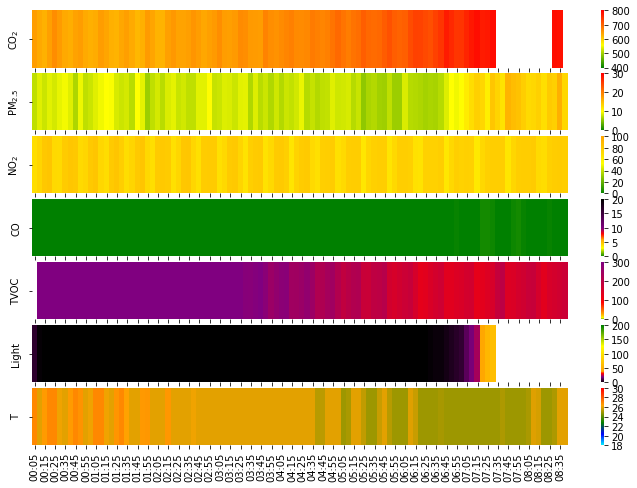

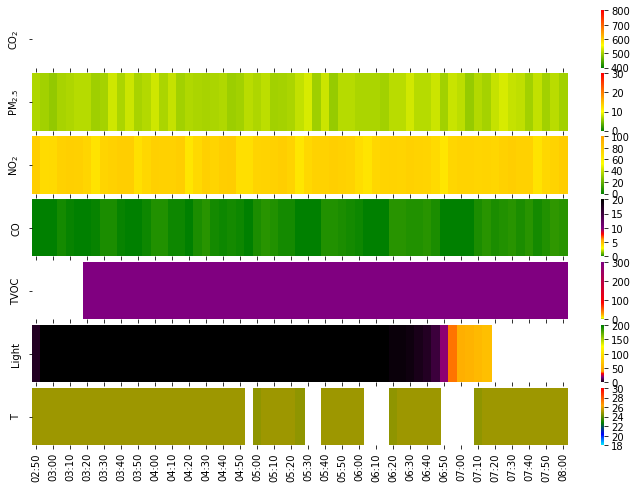

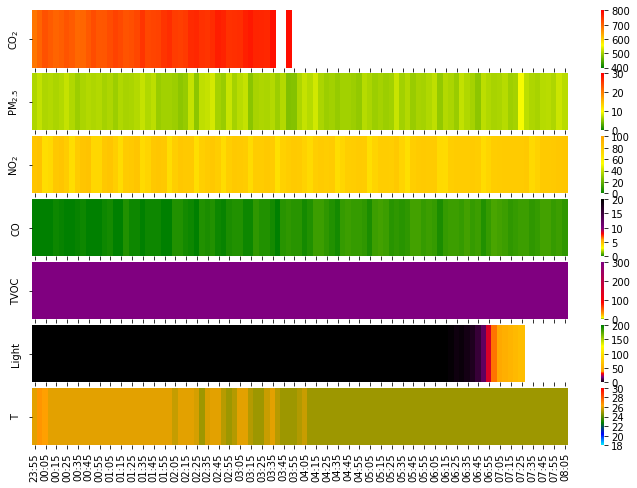

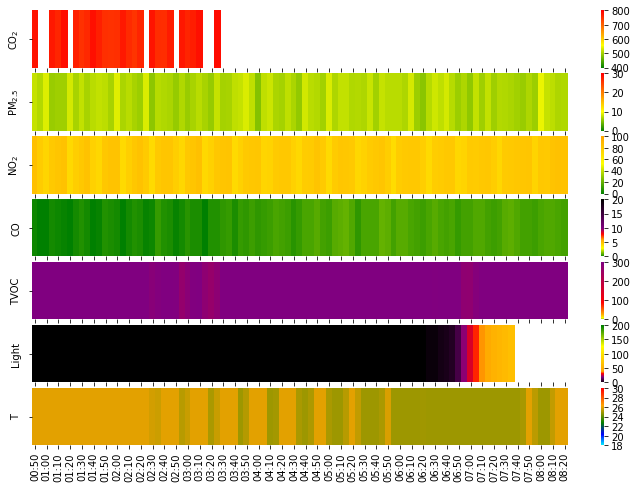

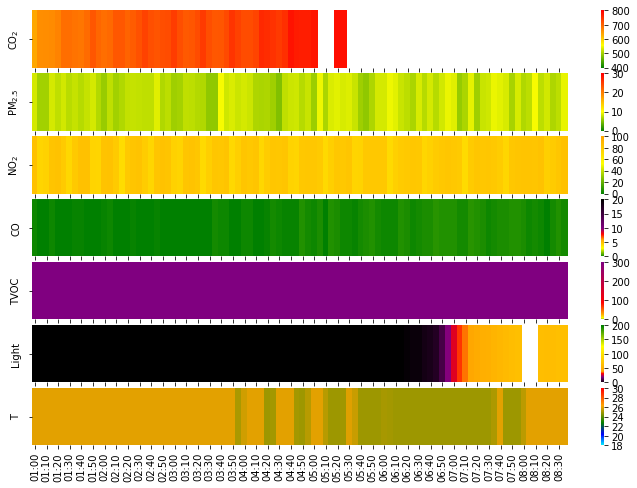

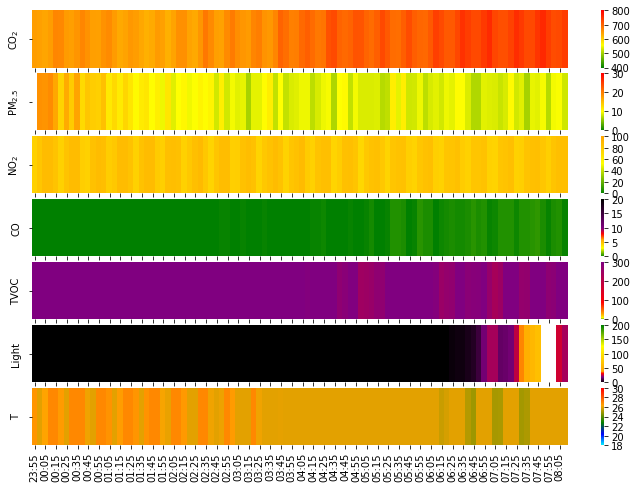

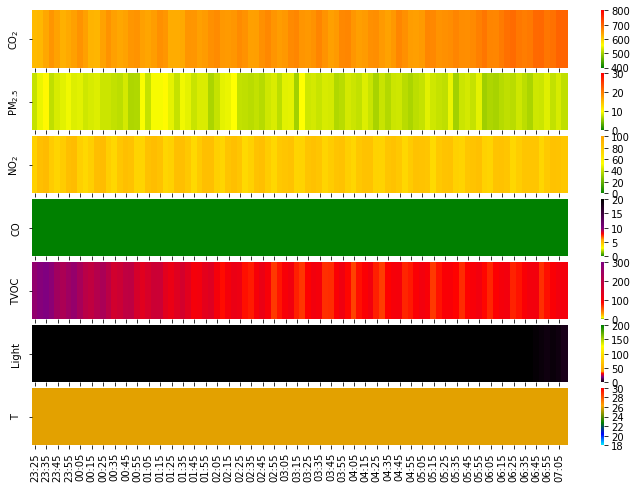

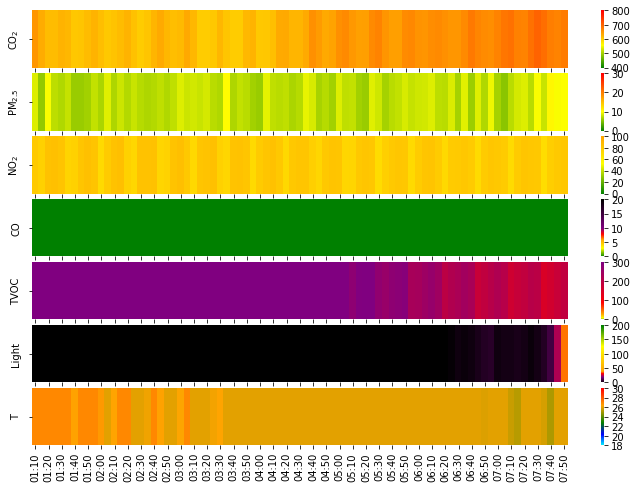

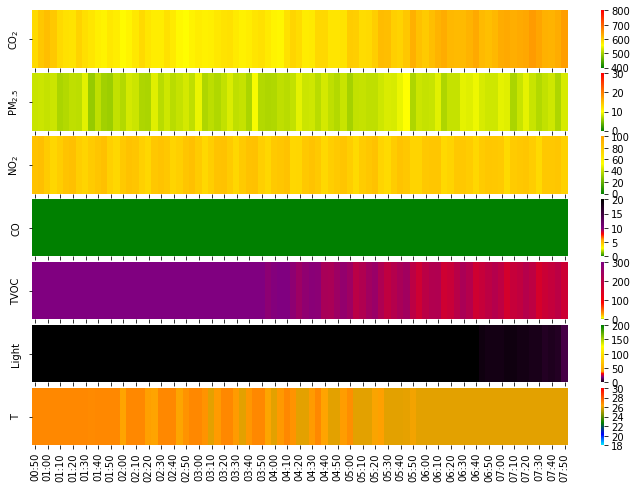

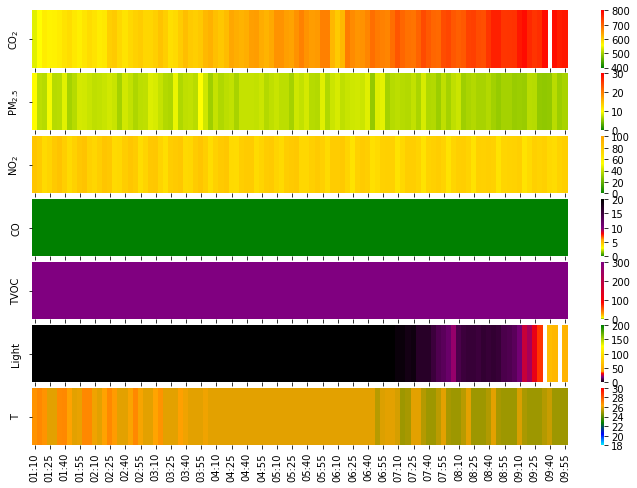

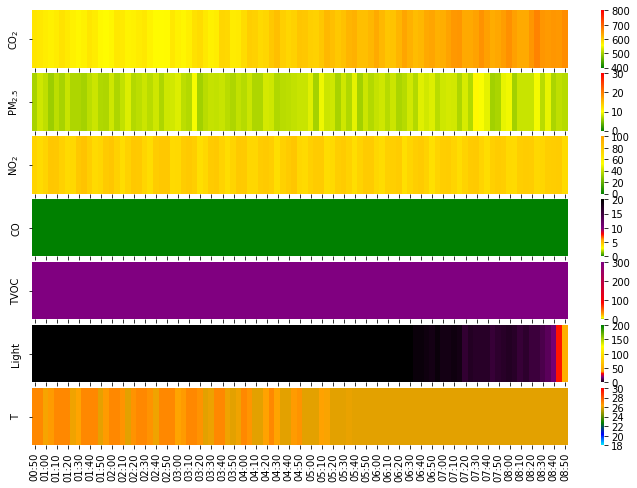

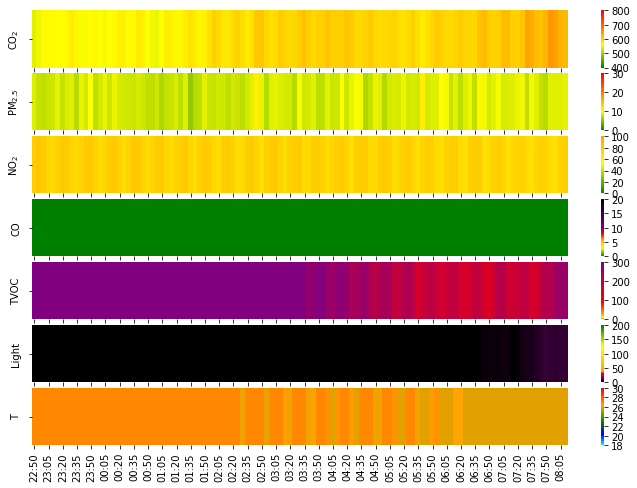

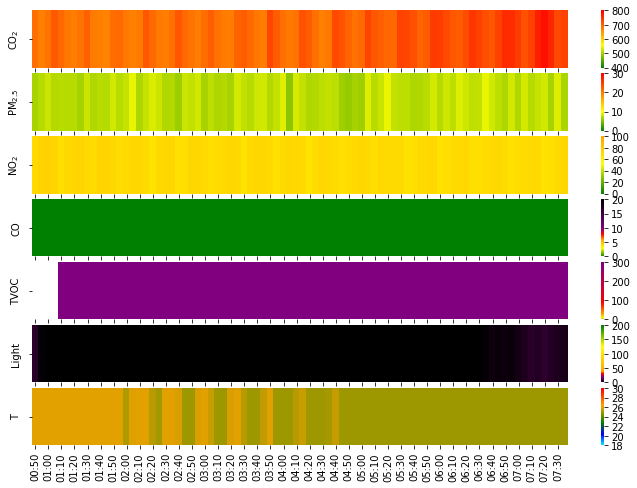

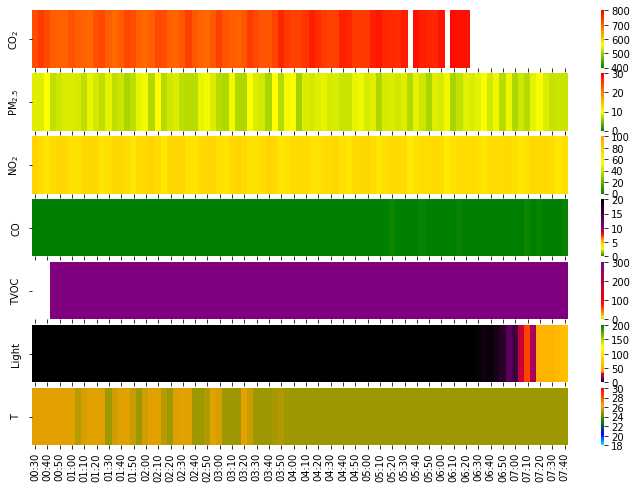

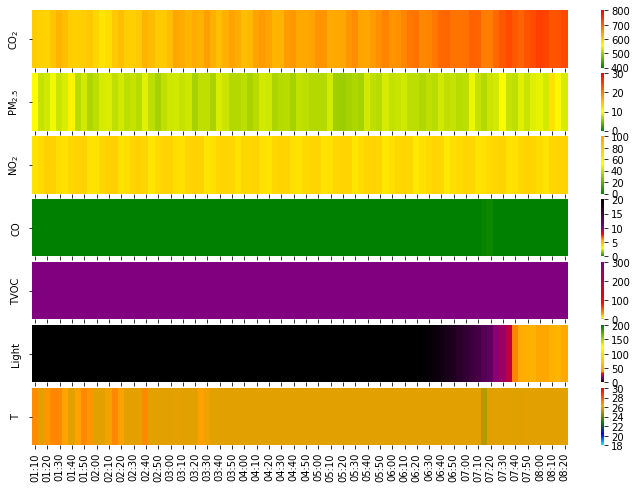

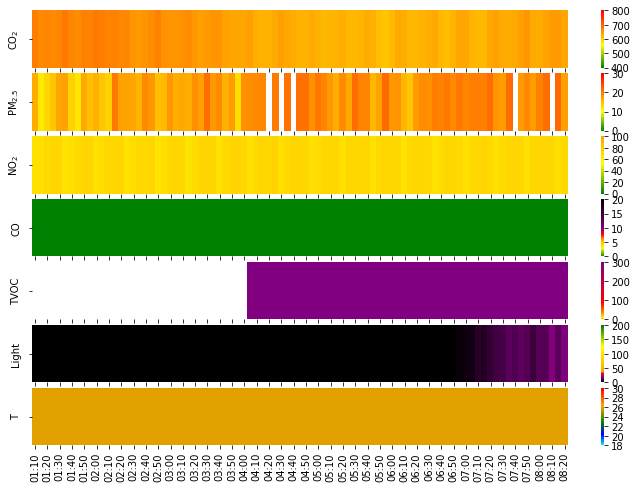

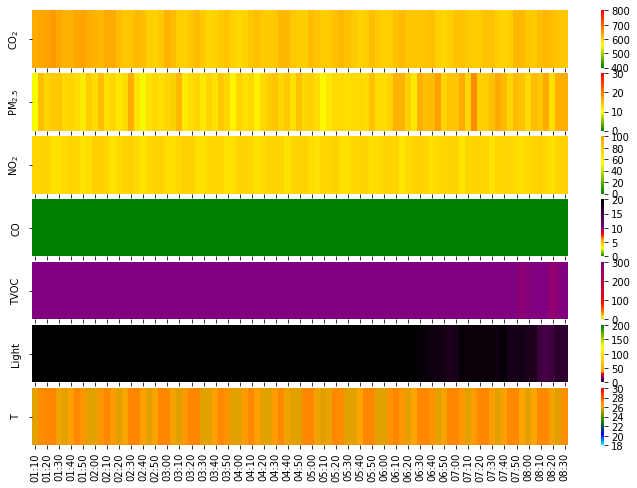

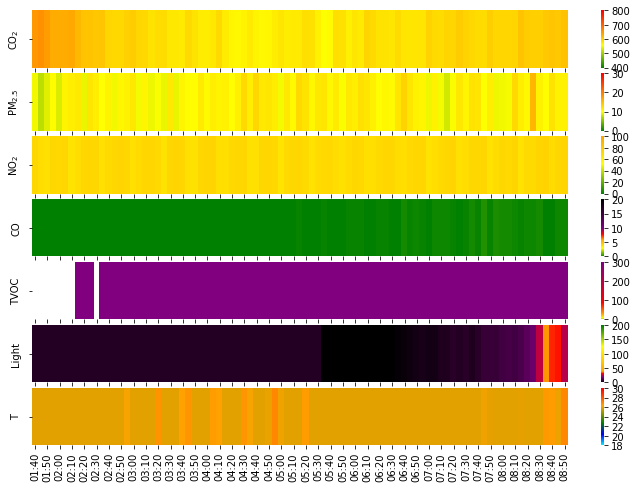

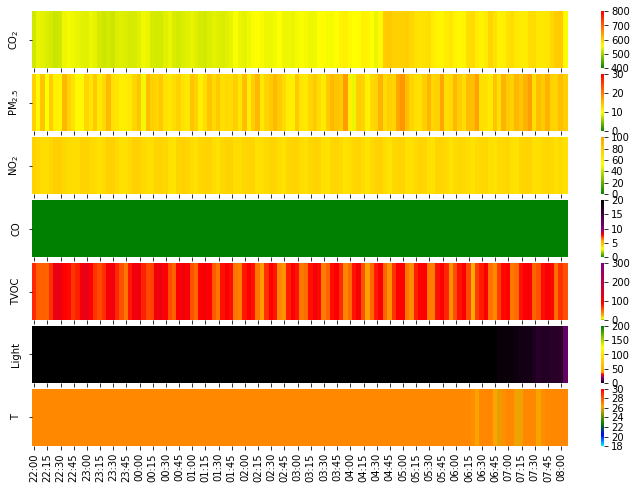

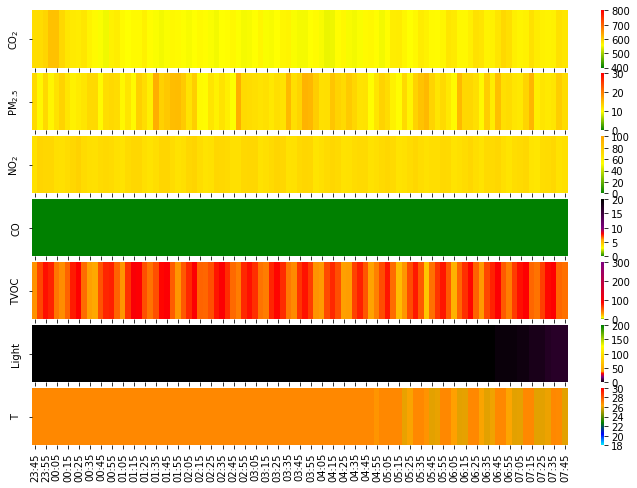

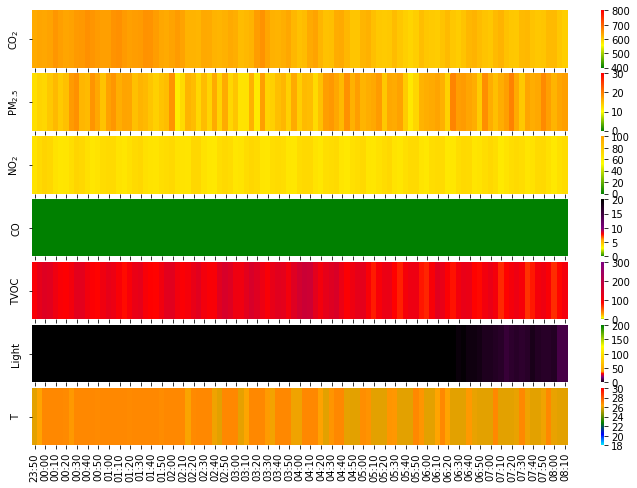

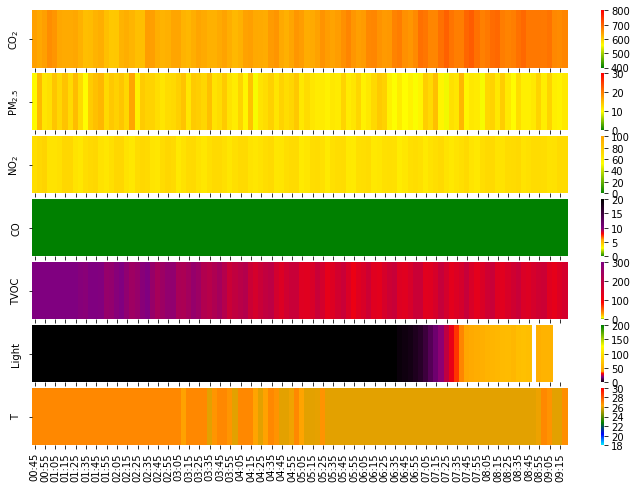

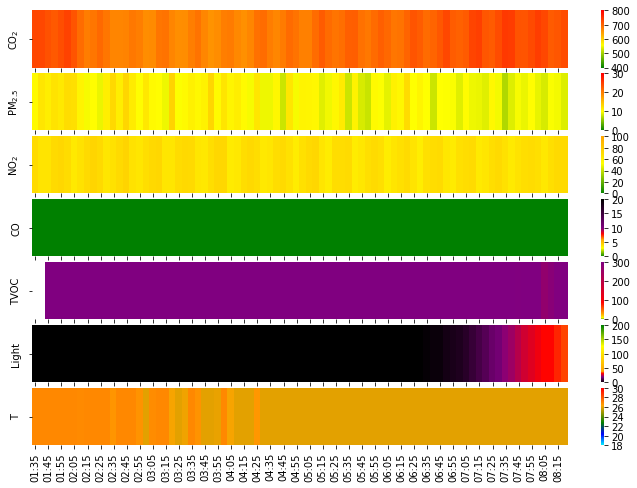

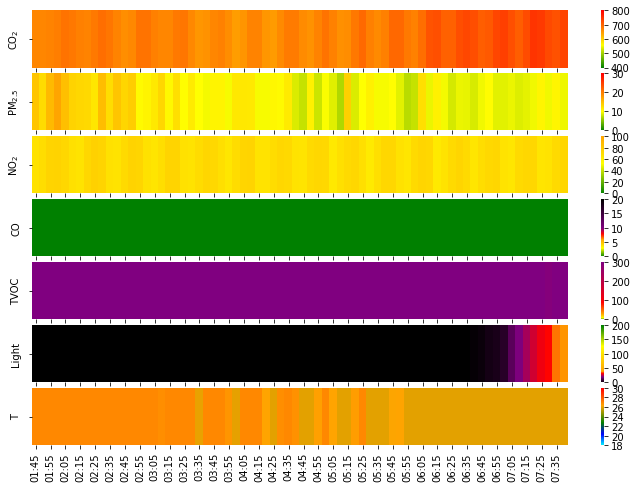

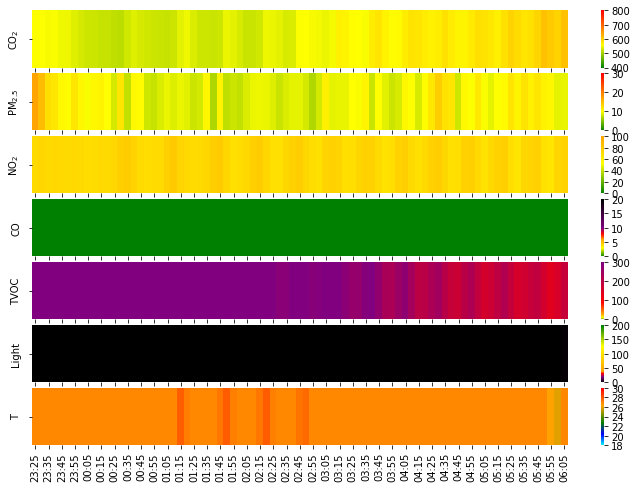

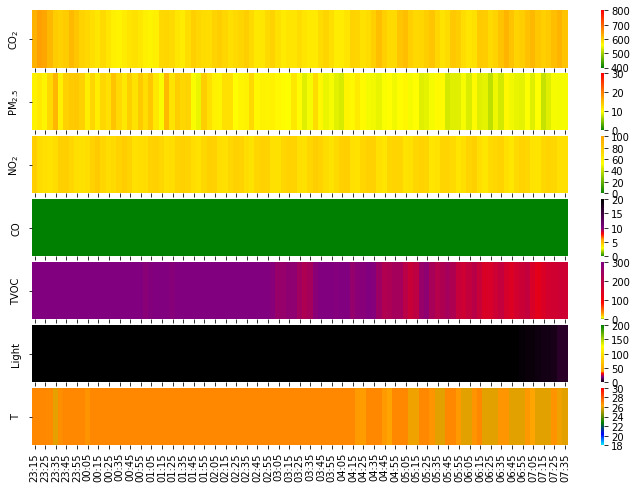

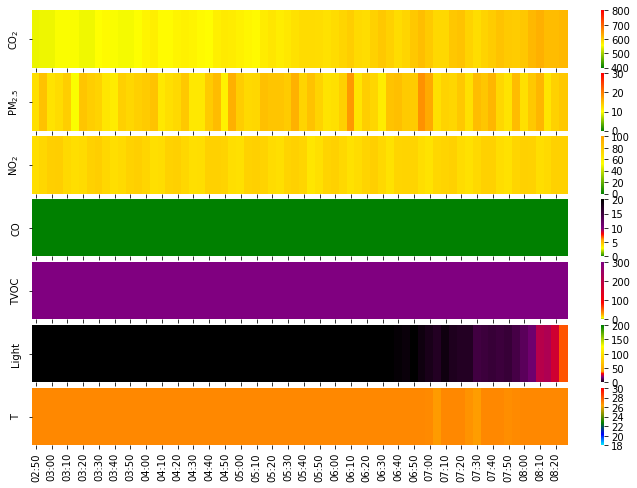

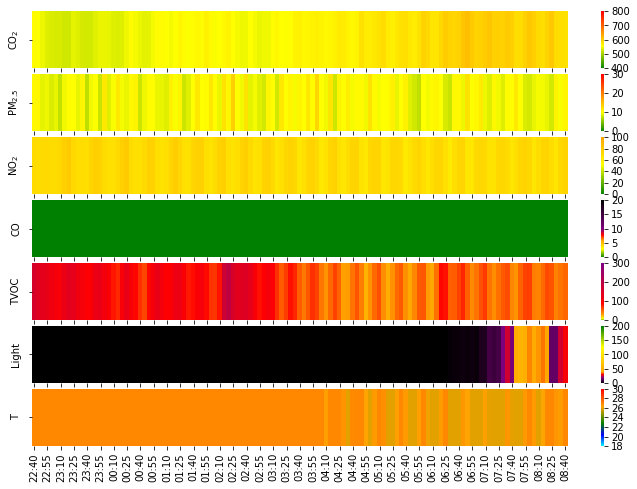

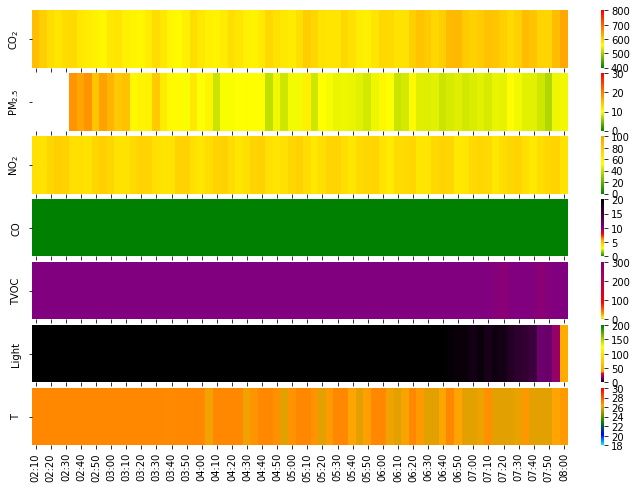

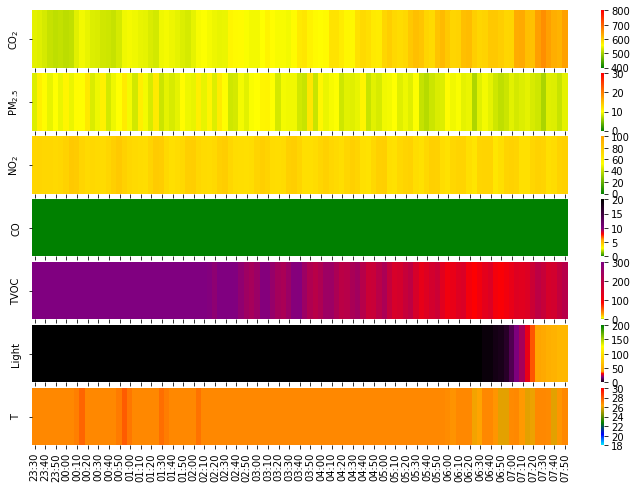

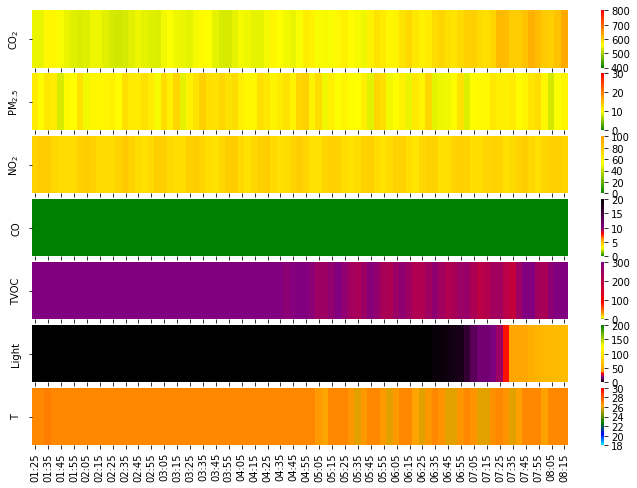

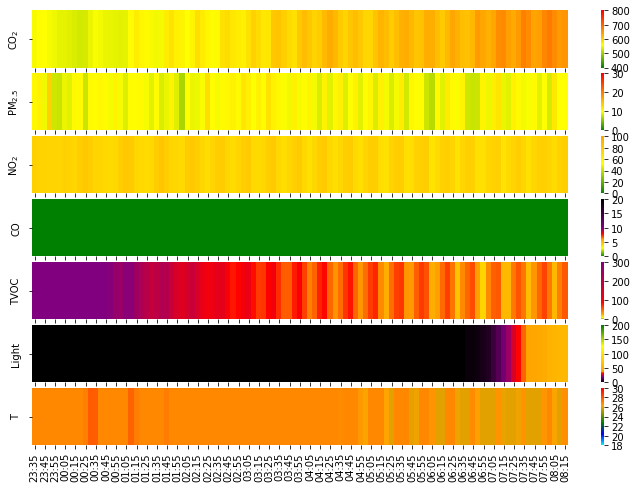

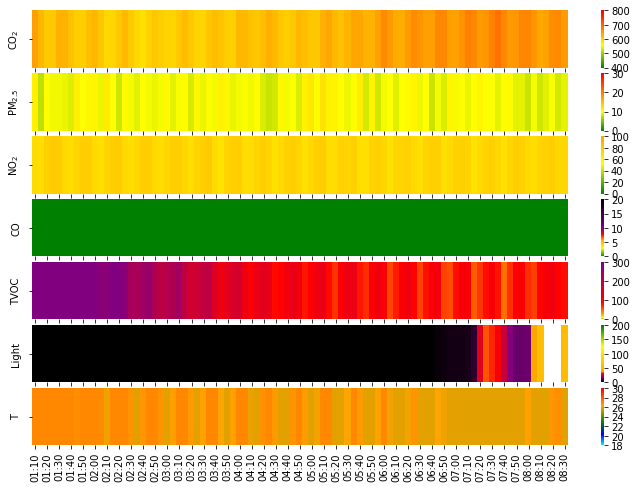

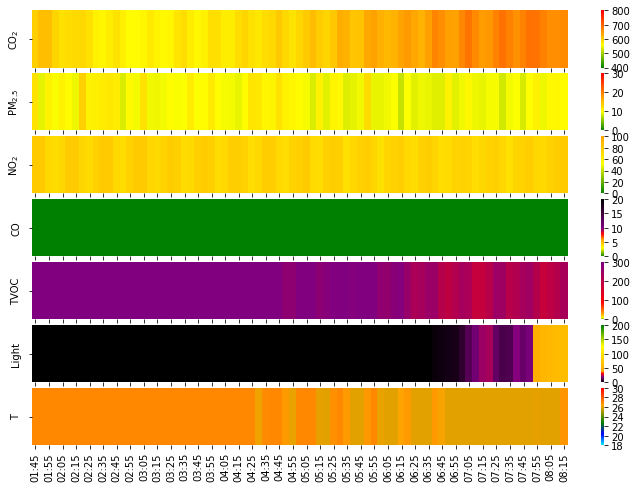

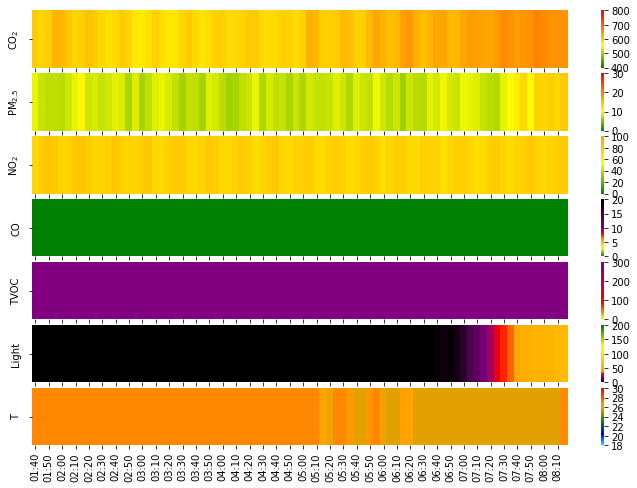

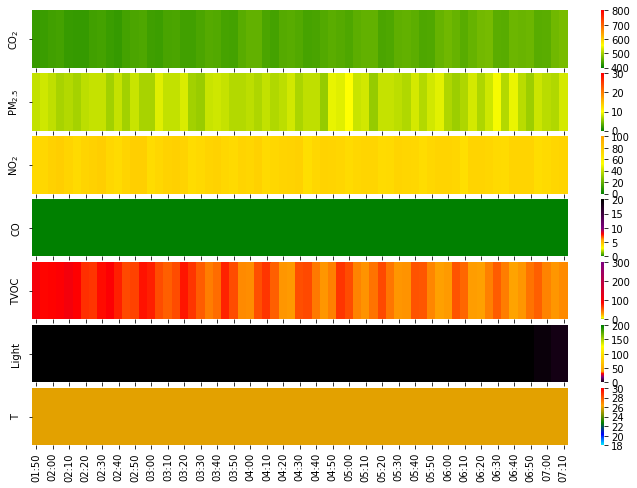

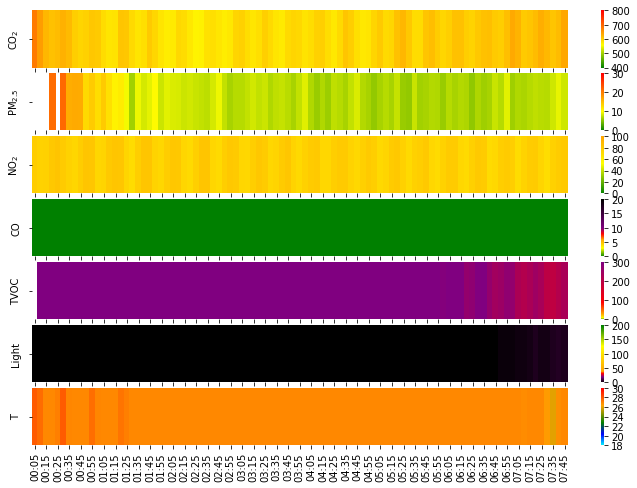

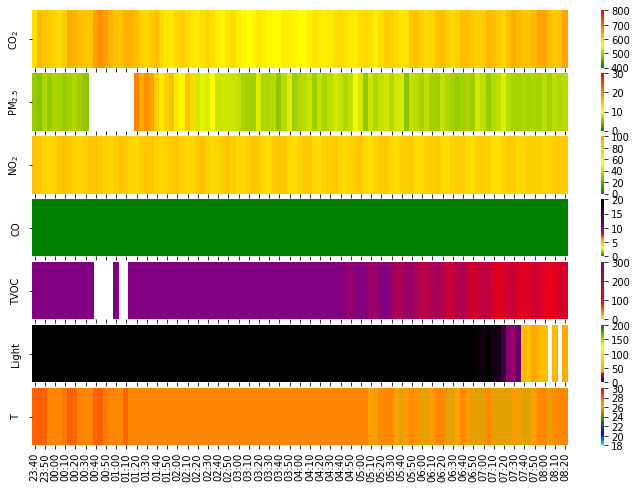

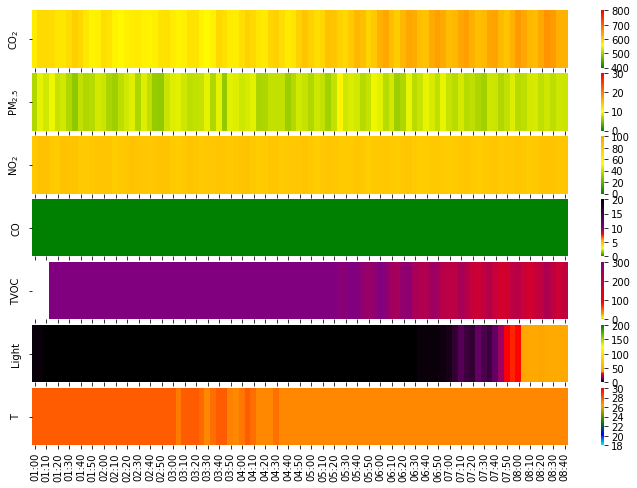

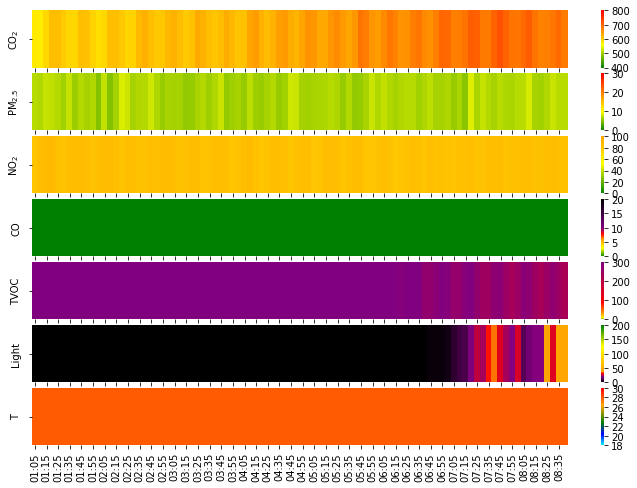

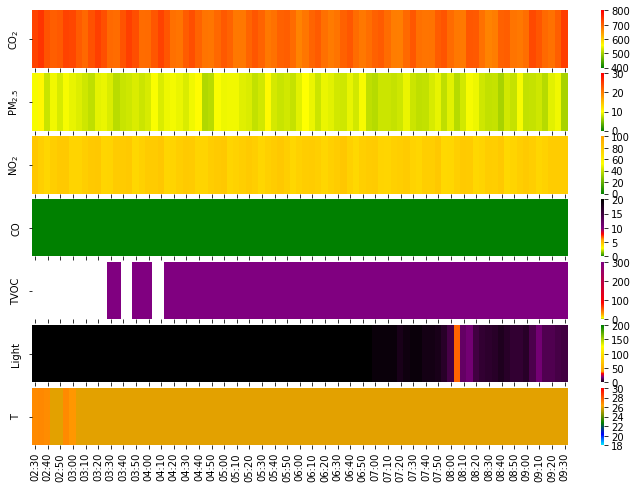

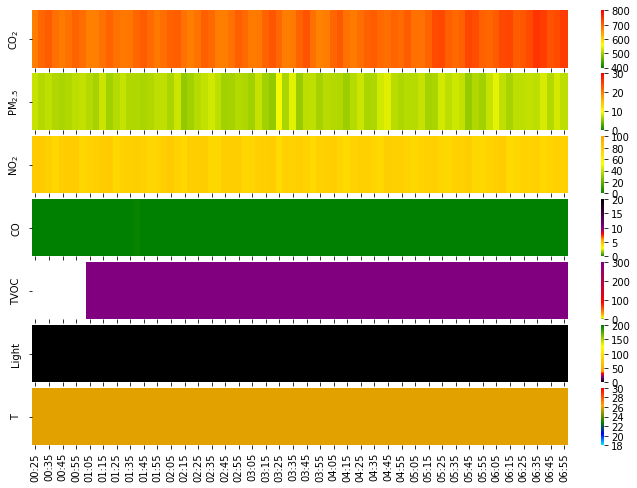

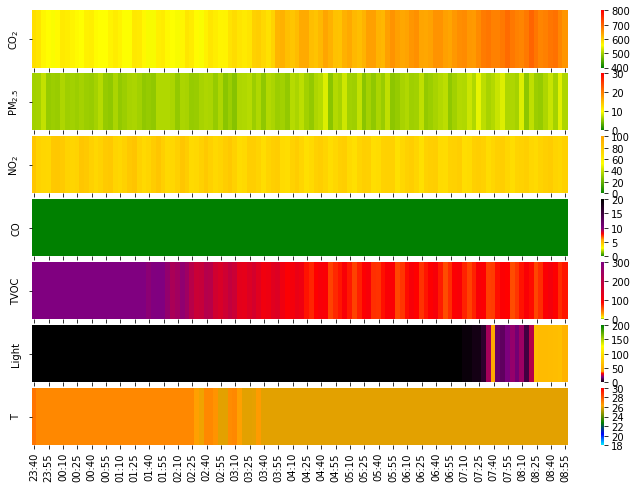

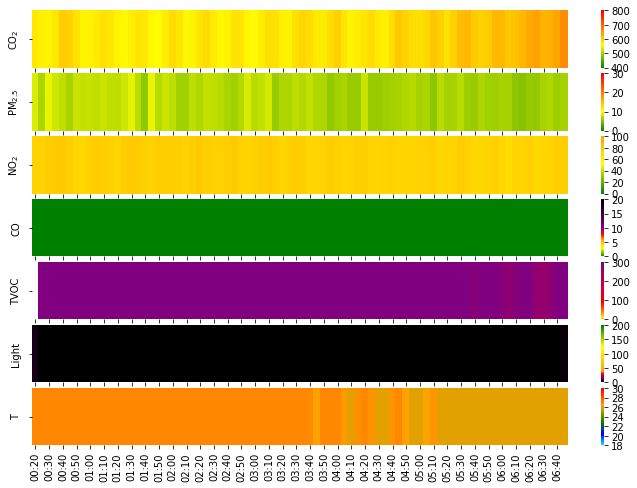

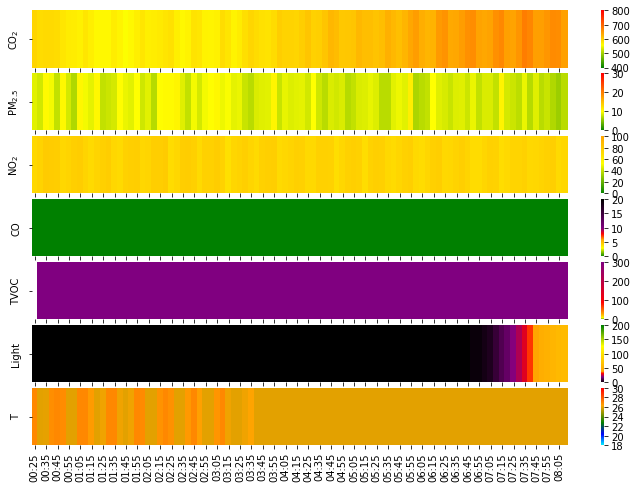

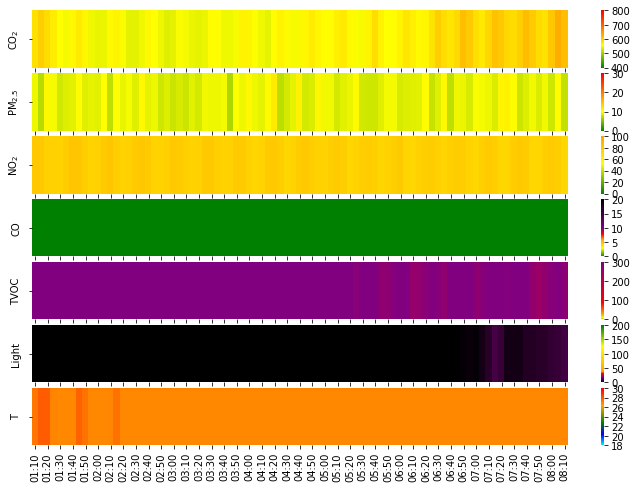

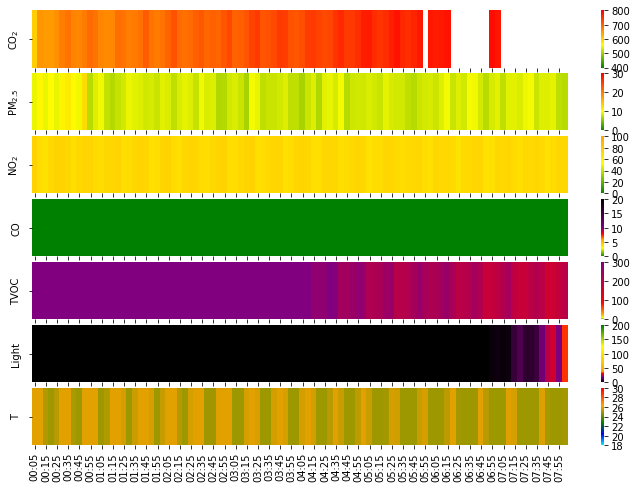

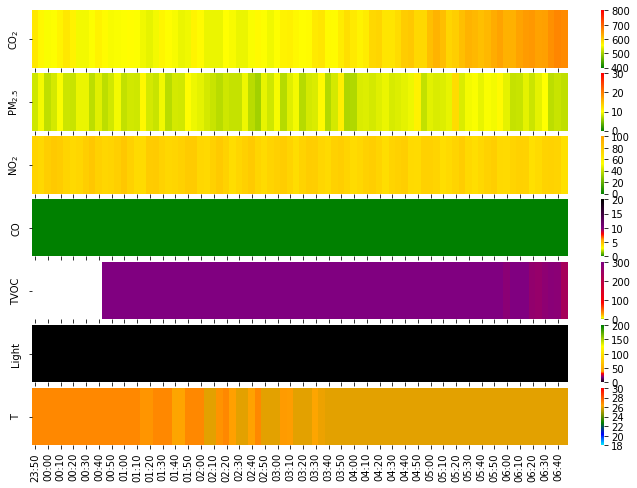

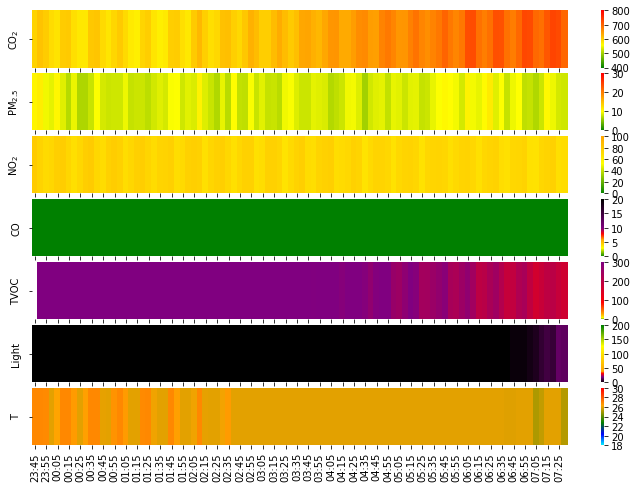

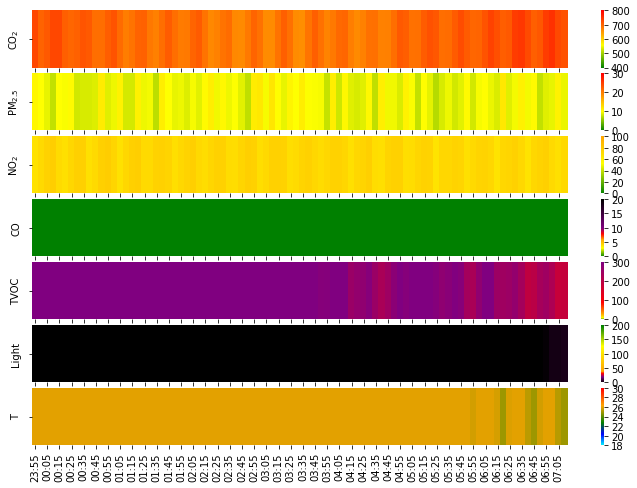

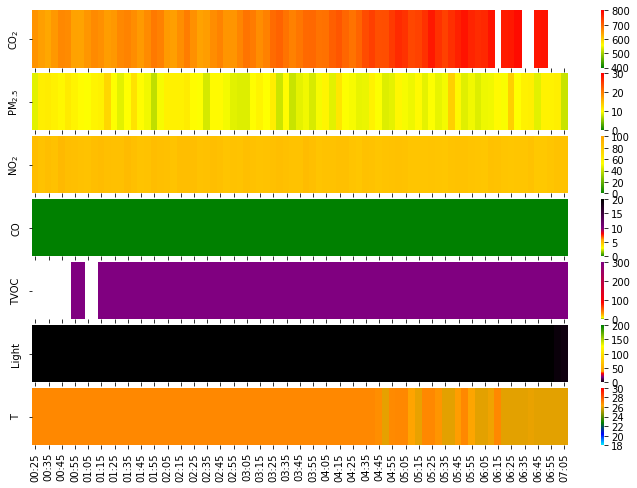

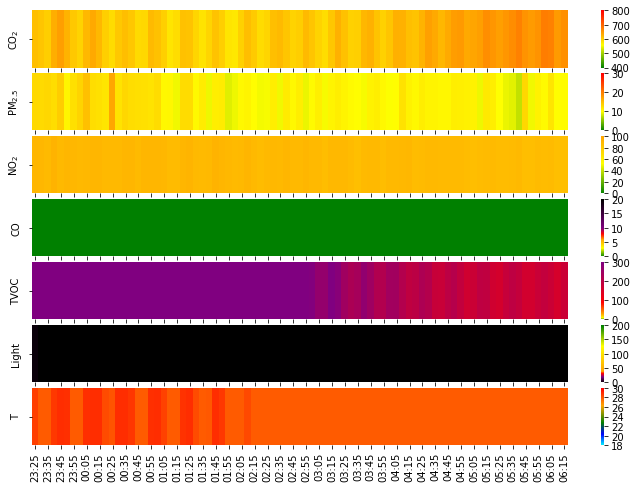

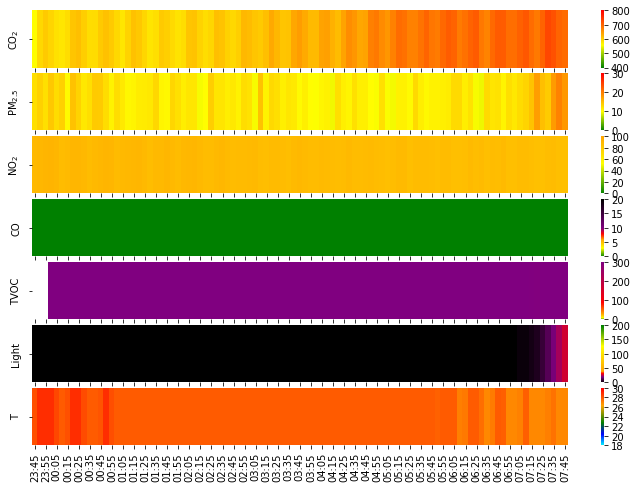

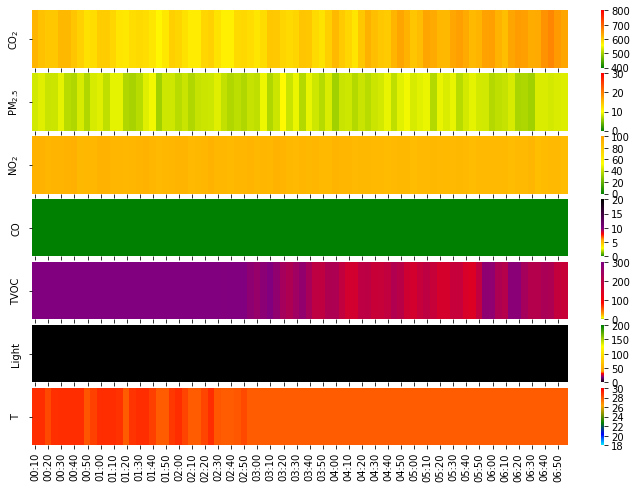

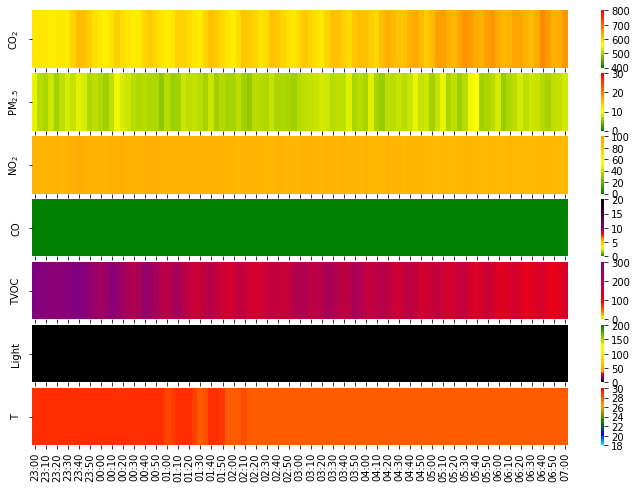

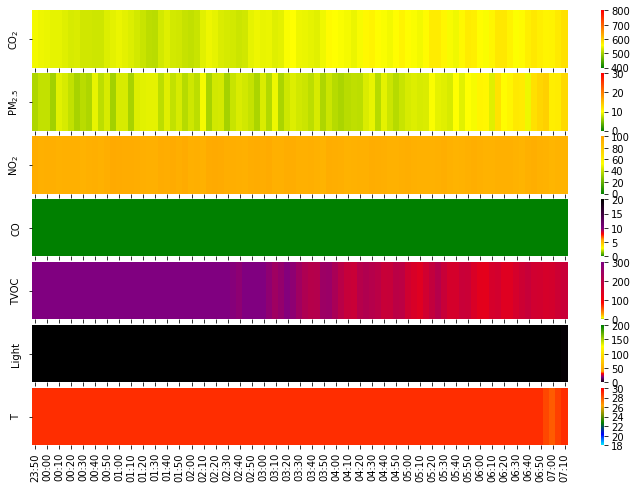

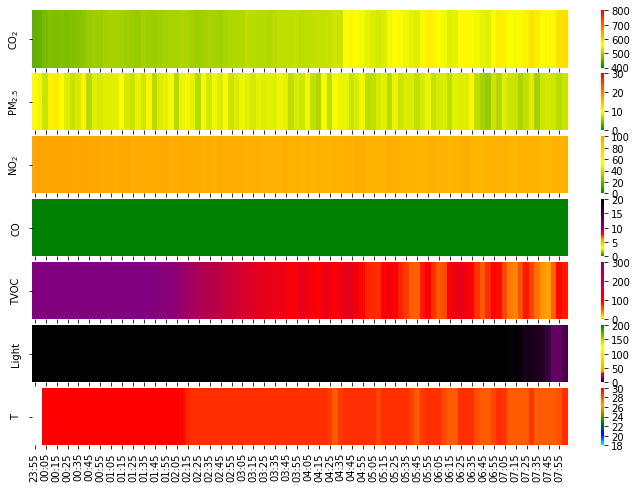

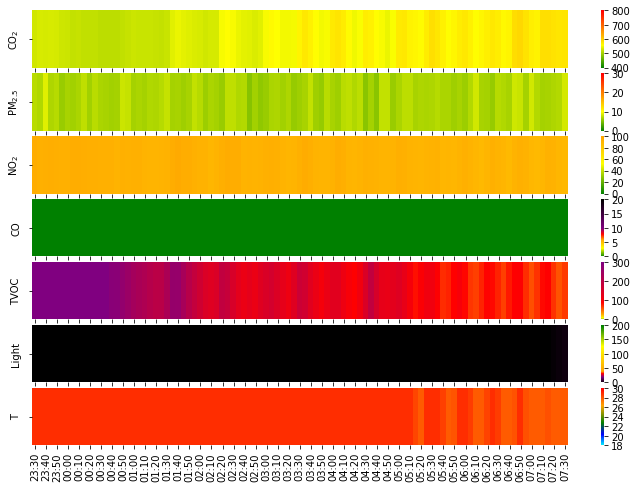

KeyboardInterrupt: 

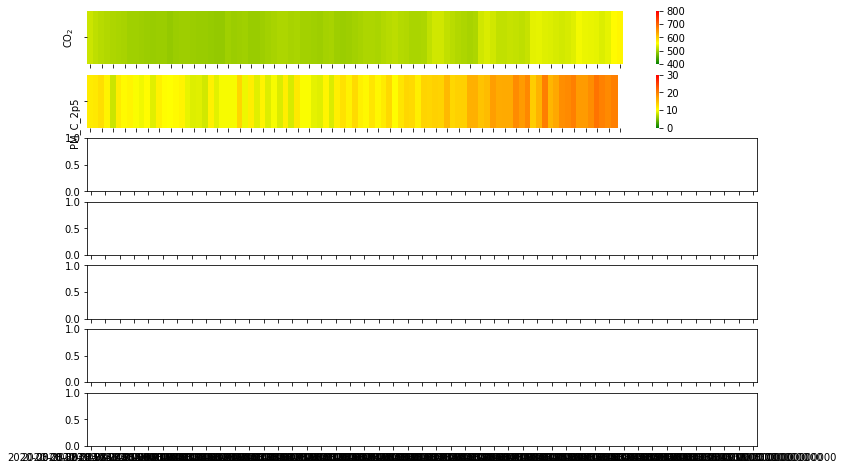

In [17]:
for pt in ['vr9j5rry']:
    iaq_night_beacon = iaq_fb[iaq_fb['Beiwe'] == pt]
    for night in iaq_night_beacon['start_time'].unique():
        single_night = iaq_night_beacon[iaq_night_beacon['start_time'] == night]
        single_night_pollutants = single_night[['CO2','PM_C_2p5','NO2','CO','TVOC','Lux','T_CO']]
        if len(single_night_pollutants['CO2'] > 10):
            fig, axes = plt.subplots(7,1,figsize=(12,8),sharex=True)
            ylabels = ['CO$_2$',
                       'PM$_{2.5}$',
                       'NO$_2$',
                       'CO',
                       'TVOC',
                       'Light',
                       'T']
            cbar_ticks = [np.arange(400,900,100),
                          np.arange(0,40,10),
                          np.arange(0,120,20),
                          np.arange(0,25,5),
                          np.arange(0,400,100),
                          np.arange(0,250,50),
                          np.arange(18,32,2)]
            cmaps = [create_cmap(["green", "yellow", "orange", "red",],[0.0, 0.4, 0.6, 1]),
                     create_cmap(["green", "yellow", "red"],[0.0, 0.34, 1]),
                     create_cmap(["green", "yellow", "orange"],[0.0, 0.53, 1]),
                     create_cmap(["green", "yellow", "orange", "red", "purple", "black"],[0.0, 0.15, 0.3, 0.4, 0.5, 1]),
                     create_cmap(["green", "yellow", "orange", "red", "purple"],[0.0, 0.03, 0.1, 0.3, 1]),
                     create_cmap(["black","purple","red","orange","yellow","green"],[0.0, 0.1, 0.16, 0.2, 0.64, 1]),
                     create_cmap(["cyan","blue","green","orange","red"],[0.0, 0.2, 0.4, 0.7, 1])]
            for ax, var, low, high, ylabel, ticks, cmap in zip(axes,single_night_pollutants.columns,[400,0,0,0,0,0,18],[800,30,100,20,300,200,30],ylabels,cbar_ticks,cmaps):
                sns.heatmap(single_night_pollutants[[var]].T,vmin=low,vmax=high,ax=ax,cbar_kws={'ticks':ticks},cmap=cmap)
                ax.set_ylabel(ylabel)
                ax.set_yticklabels([''])
                ax.set_xlabel('')

            xlabels = ax.get_xticklabels()
            new_xlabels = []
            for label in xlabels:
                new_xlabels.append(label.get_text()[11:16])

            ax.set_xticklabels(new_xlabels)
            plt.subplots_adjust(hspace=0.1)
            plt.show()
            plt.close()